# TP3: Problemas NP-Completos

In [1]:
import time
import random
# pip install matplotlib
from matplotlib import pyplot as plt
# pip install tabulate
from tabulate import tabulate
# pip install pulp
import pulp


### ¿Hitting-Set Problem está en NP?

In [2]:
#Verificamos la solucion polinomialmente
def verificar_solucion(B, C, k):
    if len(C) > k:
        return False
    satisface_Bi = [False] * len(B)

    for c in C:                      # O(#C) 
        for i in range(len(B)):
            if c in B[i]:            # O(#B[i])
                satisface_Bi[i] = True

    return all(satisface_Bi)      # O(#B)         

### Funciones auxiliares


In [3]:
# Recibe el path con el archivo a leer.
# Leemos y devolvemos un array de listas, donde cada lista posee los jugadores que piden los diferentes medios y periodistas.
def obtener_pedidos_de_la_prensa(path):
    with open(path, 'r') as archivo:
        lineas = archivo.readlines()

    pedidos_de_la_prensa = []

    for linea in lineas:
        preseleccion_linea = linea.strip().split(',')
        pedidos_de_la_prensa.append(preseleccion_linea)

    return pedidos_de_la_prensa

# Recibe una lista de listas, donde cada lista posee los jugadores que piden los diferentes medios y periodistas.
# Devuelve un set con todos los jugadores que son solicitados por la prensa.
def obtener_todos_jugadores(pedidos_de_la_prensa):
    jugadores = set()
    for pedido in pedidos_de_la_prensa:
        for jugador in pedido:
            jugadores.add(jugador)
    return jugadores

In [4]:
# Clase que representa el resultado.
# Recibe el nombre del archivo, la cantidad minima de jugadores que resuelve y los jugadores que se seleccionaron como solucion.
class Resultado:
    def __init__(self, nombre_archivo, cantidad_minima, jugadores):
        self.nombre_archivo = nombre_archivo
        self.cantidad_minima = cantidad_minima
        self.jugadores = jugadores
        

def obtener_resultados_esperados(nombre_archivo):
    with open(nombre_archivo, 'r') as archivo:
        contenido = archivo.read() 
    resultados = []

    # Separa el contenido en bloques
    bloques = contenido.split('\n\n')
    
    # Itera a través de cada bloque y busca ".txt" (para obtener el nombre del archivo) y 
    # "Cantidad" (para obtener la cantidad minima de jugadores que resuelve y los jugadores que se seleccionaron como solucion)
    for bloque in bloques:
        nombre_archivo = ''
        cantidad_minima = 0
        jugadores = []

        lineas = bloque.split('\n')
        for linea in lineas:
            if ".txt" in linea:
                nombre_archivo = linea
            if 'Cantidad' in linea:
                cantidad_minima = int(linea.split(":")[1].split("(")[0].strip())
                jugadores_linea = linea.split("(")[1].split(")")[0]
                jugadores = [jugador.strip() for jugador in jugadores_linea.split(",")]
                resultados.append(Resultado(nombre_archivo, cantidad_minima, jugadores))

    return resultados


### Sets de datos

In [5]:
#Paths de los archivos de la catedra
path_5 = 'sets/sets de la catedra/5.txt'
path_7 = 'sets/sets de la catedra/7.txt'
path_10_pocos = 'sets/sets de la catedra/10_pocos.txt'
path_10_todos = 'sets/sets de la catedra/10_todos.txt'
path_10_varios = 'sets/sets de la catedra/10_varios.txt'
path_15 = 'sets/sets de la catedra/15.txt'
path_20 = 'sets/sets de la catedra/20.txt'
path_50 = 'sets/sets de la catedra/50.txt'
path_75 = 'sets/sets de la catedra/75.txt'
path_100 = 'sets/sets de la catedra/100.txt'
path_200 = 'sets/sets de la catedra/200.txt'
resultados_sets_catedra = 'sets/sets de la catedra/Resultados Esperados.txt'

#### Creación sets de datos propios

In [6]:
random.seed(0)

pedidos_de_prensa_max = obtener_pedidos_de_la_prensa(path_200)
universe = list(set([pedido for pedidos in pedidos_de_prensa_max for pedido in pedidos]))

def generar_instancia(universe_size, num_sets, max_set_size):
    sets = [{universe[random.randint(0, universe_size)] for _ in range(random.randint(1, max_set_size))} for _ in range(num_sets)]
    return sets

def generar_instancia_cant_por_jugador_fija(universe_size, num_sets, cant_jugadores):
    i = 0
    sets = []
    for _ in range(num_sets):
        current_set = set()
        while i < cant_jugadores:
            nuevo_jugador = universe[random.randint(0, universe_size)]
            while nuevo_jugador in current_set:
                nuevo_jugador = universe[random.randint(1, universe_size)]
            current_set.add(nuevo_jugador)
            i += 1
        i = 0
        sets.append(current_set)
    return sets

def crear_archivos(sets, nombre_archivo):
    with open(nombre_archivo, 'w') as archivo:
        for set in sets:
            archivo.write(','.join(set) + '\n')

sets_5 = generar_instancia(30, 5, 6)
sets_15 = generar_instancia(30, 15, 15)
sets_20 = generar_instancia(30, 20, 6)
sets_50 = generar_instancia(30, 50, 2)

# Testear como aumenta el tiempo de ejecucion a medida que aumenta la cantidad periodista
def crear_archivos_periodistas():
    for i in range(0, 30001, 150):
        sets = generar_instancia(30, i, 7)
        crear_archivos(sets, 'sets/nuestros/performance/' + str(i) + '_periodistas.txt')

# Testear con gran variacion de jugadores por periodista
def crear_archivos_periodistas_variacion_jugadores():
    for i in range(0, 30001, 150):
        sets = generar_instancia(30, i, 30)
        crear_archivos(sets, 'sets/nuestros/performance_jugadores/' + str(i) + '_periodistas.txt')
       
# Ya que tarda mucho en ejecutar, lo dejamos comentado (se puede descomentar para ejecutarlo, pero los archivos ya se generaron)
# crear_archivos(sets_5, 'sets/nuestros/5.txt')
# crear_archivos(sets_15, 'sets/nuestros/15.txt')
# crear_archivos(sets_20, 'sets/nuestros/20.txt')
# crear_archivos(sets_50, 'sets/nuestros/50.txt')
# crear_archivos_periodistas()
# crear_archivos_periodistas_variacion_jugadores()
# crear_archivos(generar_instancia(30,30000,7) , 'sets/nuestros/30k.txt')
# crear_archivos(generar_instancia(30,300000,7) , 'sets/nuestros/300k.txt')

In [7]:
#Paths de los archivos nuestros
path_5_nuestro = 'sets/nuestros/5.txt'
path_15_nuestro = 'sets/nuestros/15.txt'
path_15_un_jugador_nuestro = 'sets/nuestros/15_un_jugador.txt'
path_20_nuestro = 'sets/nuestros/20.txt'
path_50_nuestro = 'sets/nuestros/50.txt'
path_30k_nuestro = 'sets/nuestros/30k.txt'
path_300k_nuestro = 'sets/nuestros/300k.txt'

### Obtención pedidos de la prensa

In [8]:
# Sets de la catedra
pedidos_prensa_catedra = {
    '5': obtener_pedidos_de_la_prensa(path_5),
    '7': obtener_pedidos_de_la_prensa(path_7),
    '10_pocos': obtener_pedidos_de_la_prensa(path_10_pocos),
    '10_todos': obtener_pedidos_de_la_prensa(path_10_todos),
    '10_varios': obtener_pedidos_de_la_prensa(path_10_varios),
    '15': obtener_pedidos_de_la_prensa(path_15),
    '20': obtener_pedidos_de_la_prensa(path_20),
    '50': obtener_pedidos_de_la_prensa(path_50),
    '75': obtener_pedidos_de_la_prensa(path_75),
    '100': obtener_pedidos_de_la_prensa(path_100),
    '200': obtener_pedidos_de_la_prensa(path_200)
}

# Resultados esperados
resultados_esperados = obtener_resultados_esperados(resultados_sets_catedra)

# Sets nuestros
pedidos_prensa_nuestro = {
    '5': obtener_pedidos_de_la_prensa(path_5_nuestro),
    '15': obtener_pedidos_de_la_prensa(path_15_nuestro),
    '15_un_jugador': obtener_pedidos_de_la_prensa(path_15_un_jugador_nuestro),
    '20': obtener_pedidos_de_la_prensa(path_20_nuestro),
    '50': obtener_pedidos_de_la_prensa(path_50_nuestro),
    '30k': obtener_pedidos_de_la_prensa(path_30k_nuestro),
    '300k': obtener_pedidos_de_la_prensa(path_300k_nuestro)
}


### Función verificadora

In [9]:
# Recibe una lista de listas (cada lista posee los jugadores que piden los diferentes medios y periodistas) y un 
# conjunto de jugadores que se seleccionaron como solucion.
# Verifica si el conjunto C cubre a todos los B_i
# Tomamos como base la verificación del Hitting-Set Problem y lo ajustamos para nuestro problema.
def verificar_solucion_para_Scaloni(B, C):
    for subconjunto in B:
        if not any(elemento in C for elemento in subconjunto):
            return False
    return True 

### Solución por Backtracking

In [37]:
# Recibe un pedido de la prensa (B_i) y una posible solucion (C)
# Verifica si el pedido del periodista esta satisfecho por la solucion.
# Devuelve True si el pedido esta satisfecho, False en caso contrario.
def satisfecho(pedido, solucion):
    return any(jugador in pedido for jugador in solucion)

# Obtiene el conjunto minimo de jugador que satisface a todos los periodistas.
# Recibe:
# - pedidos_de_prensa: una lista de listas (cada lista posee los jugadores que piden los diferentes medios y periodistas).
# - solucion_actual: una lista con los jugadores que se seleccionaron como solucion parcial.
# - i: indice que indica el pedido de prensa que se esta analizando.
# - solucion: una lista con los jugadores que se seleccionaron como mejor solucion.
def conjunto_minimo_para_Scaloni(pedidos_de_prensa, solucion_actual, i, solucion):
    cantidad_de_jugadores = len(solucion_actual)
    largo_solucion = len(solucion)

    if(largo_solucion > 0 and cantidad_de_jugadores == largo_solucion):
        return False

    pedido_actual = pedidos_de_prensa[i]

    if satisfecho(pedido_actual, solucion_actual):
        return conjunto_minimo_para_Scaloni(pedidos_de_prensa, solucion_actual, i + 1, solucion)


    for jugador in pedido_actual:
        if largo_solucion > 0 and cantidad_de_jugadores + 1 >= largo_solucion: 
            return True

        solucion_actual.append(jugador)
        cantidad_de_jugadores += 1

        if verificar_solucion_para_Scaloni(pedidos_de_prensa[i:], solucion_actual):
            solucion[:] = solucion_actual
            largo_solucion = cantidad_de_jugadores
        else:
            valido = conjunto_minimo_para_Scaloni(pedidos_de_prensa, solucion_actual, i + 1, solucion)

            if not valido:
                solucion_actual.pop()
                break 
        solucion_actual.pop()
        cantidad_de_jugadores -= 1

    return True

In [38]:
# Obtiene el conjunto minimo de jugador que satisface a todos los pedidios_de_prensa.
# Recibe:
# - pedidos_de_prensa: una lista de listas (cada lista posee los jugadores que piden los diferentes medios y periodistas).
# Devuele:
# - solucion: una lista con los jugadores que se seleccionaron como mejor solucion.
# - tiempo_ejecucion: tiempo de ejecucion en segundos que tardo en encontrar la solucion.
def solucion_para_Scaloni(pedidos_de_prensa):
    solucion = []
    pedidos_ordenados = sorted(pedidos_de_prensa, key= len)
    tiempo_inicial = time.time()
    conjunto_minimo_para_Scaloni(pedidos_ordenados, [], 0, solucion)
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion


# Ejemplo de uso
archivo_path = path_300k_nuestro
pedidos_de_la_prensa = obtener_pedidos_de_la_prensa(archivo_path)
solucion, tiempo_ejecucion = solucion_para_Scaloni(pedidos_de_la_prensa)
print("Solucion:", solucion, "\nTiempo_ejecucion:", tiempo_ejecucion, "\nCantidad periodistas:", len(pedidos_de_la_prensa))

Solucion: ['Riquelme', 'Colo Barco', 'Armani', 'Ogro Fabianni', 'Tucu Pereyra', 'Luka Romero', 'Burrito Ortega', 'Gallardo', 'Changuito Zeballos', "Barcon't", 'Beltran', 'Simeone', 'Buonanotte', 'El fantasma de la B', 'Cuti Romero', 'Dybala', 'Dibu', 'Buendia', 'Palermo', 'Soule', 'Zapelli', 'Wachoffisde Abila', 'Mauro Zarate', 'Colidio', 'Casco', 'Chiquito Romero', 'Pezzella', 'Langoni', 'Pity Martinez', 'Di Maria', 'Messi'] 
Tiempo_ejecucion: 0.6886961460113525 
Cantidad periodistas: 300000


#### Chequeo solución 

##### 1 - Usando sets de la cátedra

In [39]:
# Lista de resultados y tiempos
resultados_obtenidos = []

# Iterar sobre los pedidos de prensa de la catedra
for key, value in pedidos_prensa_catedra.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni(value)
  resultados_obtenidos.append((key, solucion, tiempo_ejecucion))


In [41]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados = []
i = 0
for resultado_esperado in resultados_esperados:
  key, solucion, tiempo_ejecucion = resultados_obtenidos[i]
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(solucion) and \
    verificar_solucion_para_Scaloni(pedidos_prensa_catedra[key], solucion) else "No"
  resultados.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(solucion), es_correcto, tiempo_ejecucion]) 
  i += 1
print(tabulate(resultados, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))

Archivo          Cantidad mínima esperada    Cantidad mínima obtenida  Se obtuvo el resultado esperado?      Tiempo de ejecución (s)
-------------  --------------------------  --------------------------  ----------------------------------  -------------------------
5.txt                                   2                           2  Sí                                                6.17504e-05
7.txt                                   2                           2  Sí                                                9.27448e-05
10_pocos.txt                            3                           3  Sí                                                0.000208616
10_varios.txt                           6                          10  No                                                0.11875
10_todos.txt                           10                           6  No                                                0.00243378
15.txt                                  4                           4  Sí 

##### 2 - Usando sets propios

In [14]:
# Lista de resultados y tiempos
resultados_obtenidos_nuestros = []
# Iterar sobre los pedidos de prensa de la catedra
for key, value in pedidos_prensa_nuestro.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni(value)
  resultados_obtenidos_nuestros.append((key, solucion, tiempo_ejecucion))

In [15]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados_nuestros = []
i = 0
for resultado_obtenido in resultados_obtenidos_nuestros:
  archivo, solucion, tiempo_ejecucion = resultado_obtenido
  es_correcto = "Sí" if verificar_solucion_para_Scaloni(pedidos_prensa_nuestro[archivo], solucion) else "No"
  resultados_nuestros.append([archivo + '.txt', len(solucion), es_correcto , tiempo_ejecucion]) 
  i += 1
print(tabulate(resultados_nuestros, headers=['Archivo', 'Cantidad minima obtenida', 'Es válida la solución?', 'Tiempo de ejecución (s)']))

Archivo              Cantidad minima obtenida  Es válida la solución?      Tiempo de ejecución (s)
-----------------  --------------------------  ------------------------  -------------------------
5.txt                                       3  Sí                                      9.25064e-05
15.txt                                      4  Sí                                      5.55515e-05
15_un_jugador.txt                          14  Sí                                      5.4121e-05
20.txt                                      8  Sí                                      0.000212908
50.txt                                     20  Sí                                      0.00103903
30k.txt                                    31  Sí                                      0.0414152
300k.txt                                   31  Sí                                      0.648159


### Solución por Programación Lineal

In [30]:
# Obtiene el conjunto minimo de jugador que satisface a todos los periodistas utilizando programacion lineal entera.
# Recibe:
# - pedidos_de_prensa: una lista de listas (cada lista posee los jugadores que piden los diferentes medios y periodistas).
# Devuele:
# - solucion: una lista con los jugadores que se seleccionaron como mejor solucion.
# - tiempo_ejecucion: tiempo de ejecucion en segundos que tardo en encontrar la solucion.
def solucion_para_Scaloni_LP(pedidos_de_prensa):
    tiempo_inicial = time.time()
    prob = pulp.LpProblem("Scaloni", pulp.LpMinimize)
    jugadores = obtener_todos_jugadores(pedidos_de_prensa)
    x = pulp.LpVariable.dicts("x", jugadores, lowBound=0, upBound=1, cat="Integer")
    prob += pulp.lpSum([x[i] for i in jugadores])
    for pedido in pedidos_de_prensa:
        prob += pulp.lpSum([x[jugador] for jugador in pedido]) >= 1
    prob.solve()
    solucion = [x[i] for i in jugadores if x[i].value() == 1]
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion

In [ ]:
# Elimina el valor x_ de los nombres de los jugadores y reemplaza los _ por espacios. Devuelve el resultado modificado.
# Recibe:
# - resultado: solución obtenida por el metodo de programacion lineal entera, donde cada jugador es un objeto de la clase LpVariable.
def arreglar_resultado(resultado):
  if isinstance(resultado[0], str):
    return resultado
  return [jugador.name.replace('x_', '').replace('_', ' ') for jugador in resultado]

##### 1 - Sets de la cátedra

In [ ]:
# Lista de resultados y tiempos
resultados_obtenidos_lp = []
# Iterar sobre los pedidos de prensa de la catedra
for archivo, value in pedidos_prensa_catedra.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni_LP(value)
  solucion = arreglar_resultado(solucion)
  resultados_obtenidos_lp.append((archivo, solucion, tiempo_ejecucion))

In [ ]:
resultados_lp = []
i = 0
for resultado_esperado in resultados_esperados:
  archivo, solucion, tiempo_ejecucion = resultados_obtenidos_lp[i]
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(solucion) and \
    verificar_solucion_para_Scaloni(pedidos_prensa_catedra[archivo],solucion) else "No"
  resultados_lp.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(solucion), es_correcto, tiempo_ejecucion]) 
  i += 1

print(tabulate(resultados_lp, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))


##### 2 - Sets propios

In [ ]:
# Lista de resultados y tiempos
resultados_obtenidos_lp_nuestros = []
# Iterar sobre los pedidos de prensa de la catedra
for archivo, value in pedidos_prensa_nuestro.items():
  solucion, tiempo_ejecucion = solucion_para_Scaloni_LP(value)
  solucion = arreglar_resultado(solucion)
  resultados_obtenidos_lp_nuestros.append((archivo, solucion, tiempo_ejecucion))

In [ ]:
# Imprime los resultados obtenidos y los esperados en una tabla
resultados_lp_nuestros = []
i = 0
for resultado_obtenido in resultados_obtenidos_lp_nuestros:
  archivo, solucion, tiempo_ejecucion = resultado_obtenido
  es_correcto = "Sí" if verificar_solucion_para_Scaloni(pedidos_prensa_nuestro[archivo],solucion) else "No"
  resultados_lp_nuestros.append([archivo + '.txt', len(solucion), es_correcto, tiempo_ejecucion]) 
  i += 1

print(tabulate(resultados_lp_nuestros, headers=['Archivo', 'Cantidad mínima obtenida', 'Es válida?', 'Tiempo de ejecución (s)']))

### Comparación de tiempos de ejecución según cantidad de jugadores

In [16]:
def pedidos_de_la_prensa_performance(path):
    pedidos_prensa_periodistas = []
    for i in range(150, 30000,150):
        pedidos_prensa_periodistas.append(obtener_pedidos_de_la_prensa(path + str(i) + '_periodistas.txt'))
    return pedidos_prensa_periodistas

pedidos_prensa_perfo_7 = pedidos_de_la_prensa_performance('sets/nuestros/performance_hasta_7_jugadores/')
pedidos_prensa_perfo_31 = pedidos_de_la_prensa_performance('sets/nuestros/performance_hasta_31_jugadores/')
cantidad_periodistas = [i for i in range(150, 30000,150)]

##### Algoritmo de Backtracking

In [24]:
def obtener_tiempos_ejecucion(pedidos_prensa):
    tiempos_ejecucion = []
    i = 0
    for pedidos in pedidos_prensa:
        _, tiempo_ejecucion = solucion_para_Scaloni(pedidos)
        tiempos_ejecucion.append(tiempo_ejecucion)
        i += 1
    return tiempos_ejecucion

tiempos_ejecucion_perfo_7 = obtener_tiempos_ejecucion(pedidos_prensa_perfo_7)
tiempos_ejecucion_perfo_31 = obtener_tiempos_ejecucion(pedidos_prensa_perfo_31)

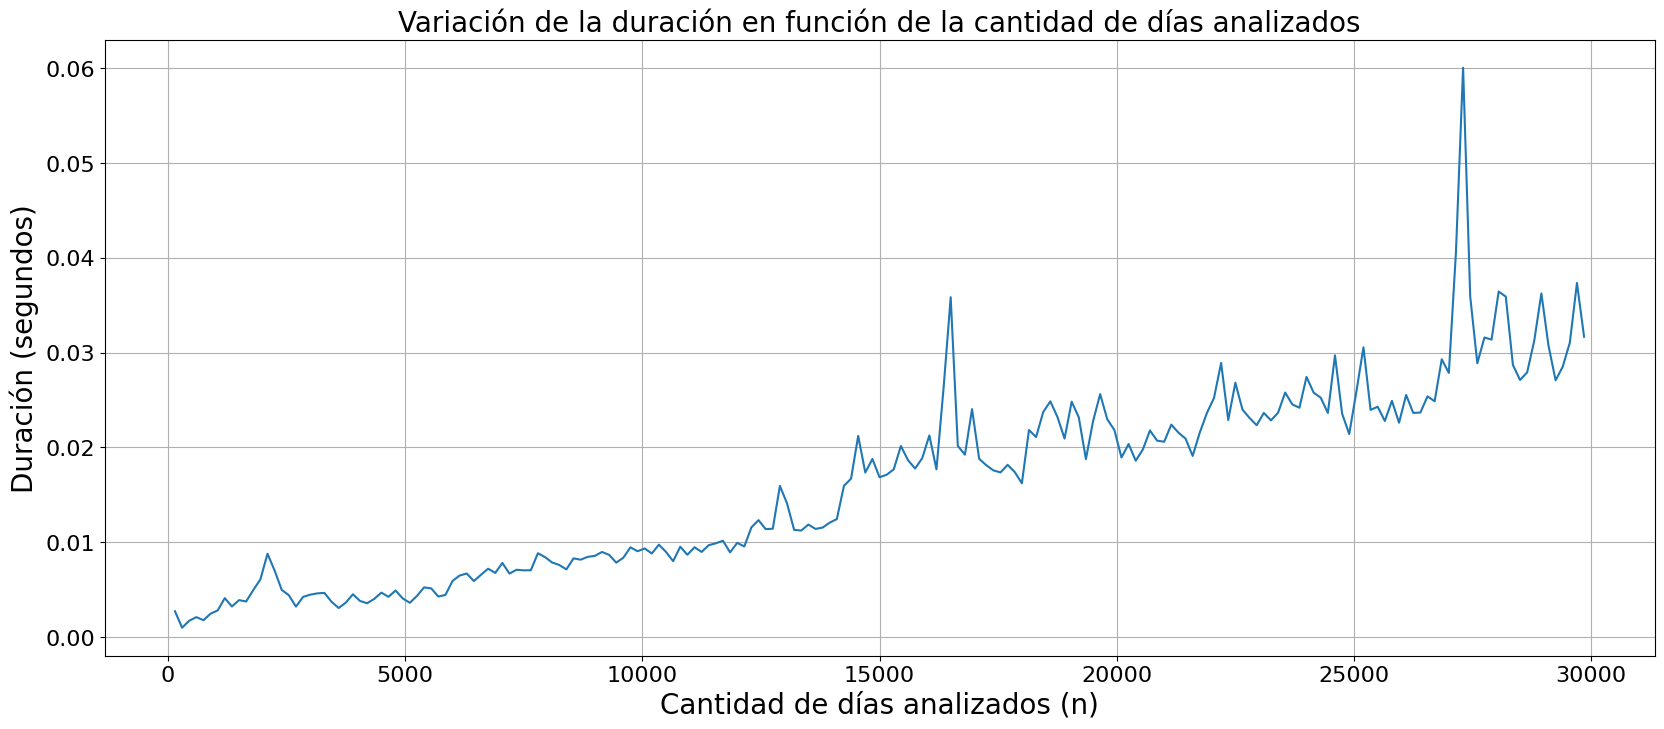

In [25]:

plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_7)
plt.xlabel('Cantidad de días analizados (n)', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de días analizados', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

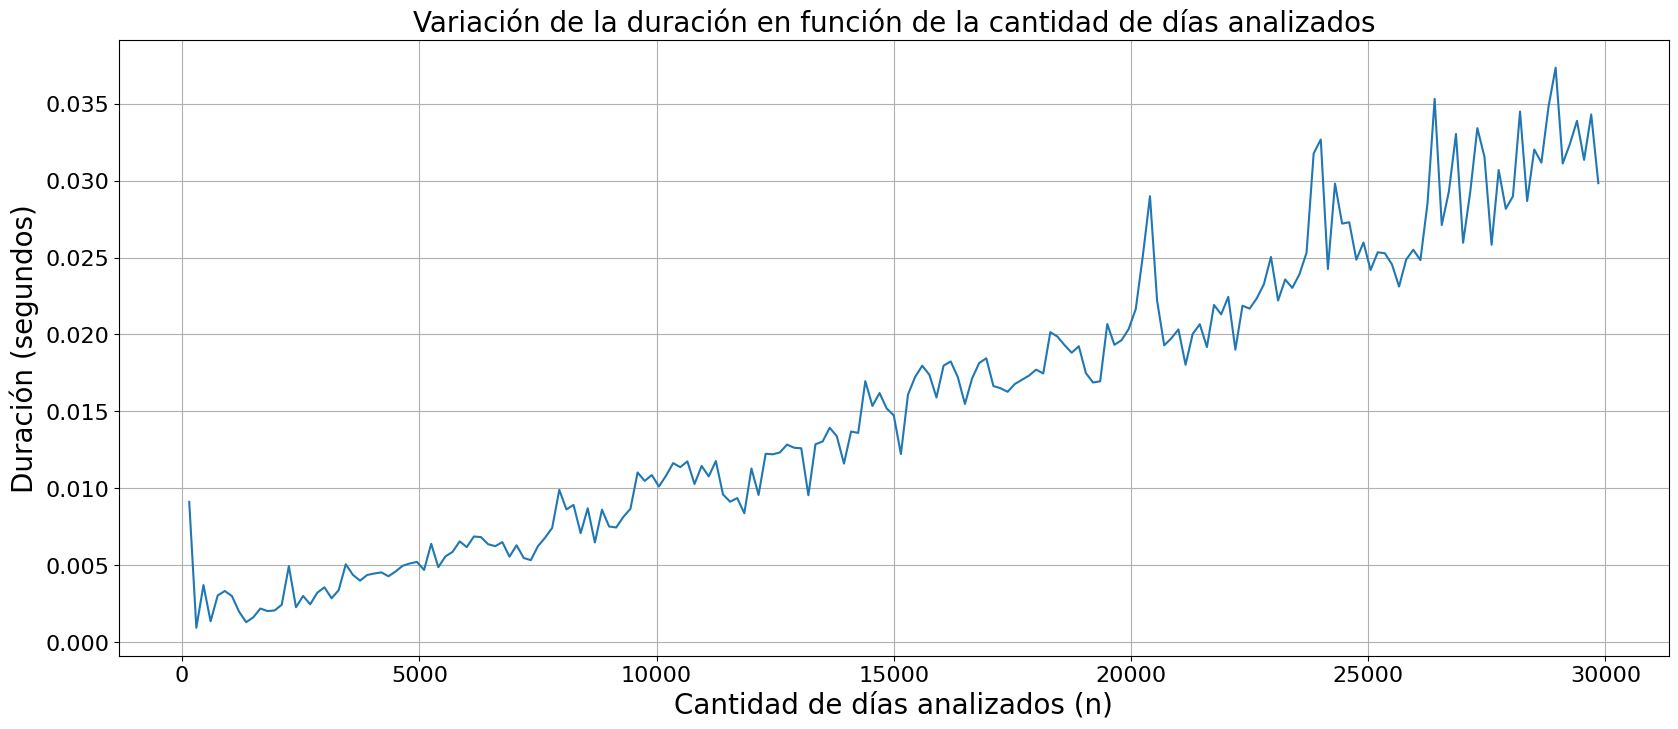

In [21]:
tiempos_ejecucion_perfo_31 = obtener_tiempos_ejecucion(pedidos_prensa_perfo_31)

plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_31)
plt.xlabel('Cantidad de días analizados (n)', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de días analizados', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

##### Algoritmo de Programacion lineal

In [ ]:
def obtener_tiempos_ejecucion_LP(pedidos_prensa):
    tiempos_ejecucion = []
    i = 0
    for pedidos in pedidos_prensa:
        _, tiempo_ejecucion = solucion_para_Scaloni_LP(pedidos) 
        tiempos_ejecucion.append(tiempo_ejecucion)
        i += 1
    return tiempos_ejecucion

tiempos_ejecucion_perfo_7_lp = obtener_tiempos_ejecucion_LP(pedidos_prensa_perfo_7)
tiempos_ejecucion_perfo_31_lp = obtener_tiempos_ejecucion_LP(pedidos_prensa_perfo_31)

##### Comparacion

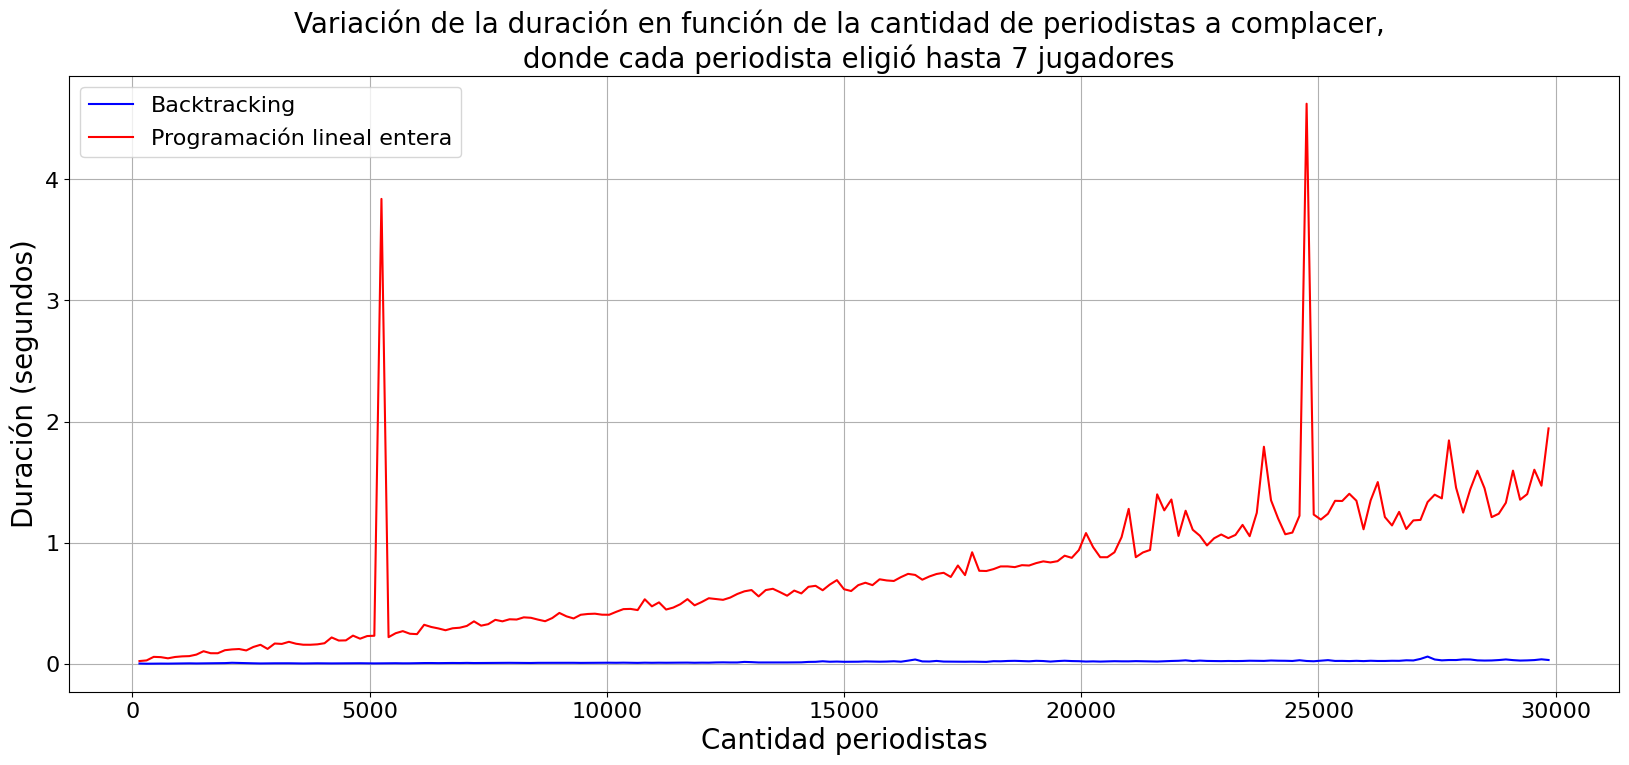

In [35]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_7, color='blue', label='Backtracking')
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_7_lp, color='red', label='Programación lineal entera')
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer, \n donde cada periodista eligió hasta 7 jugadores', fontsize=20)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


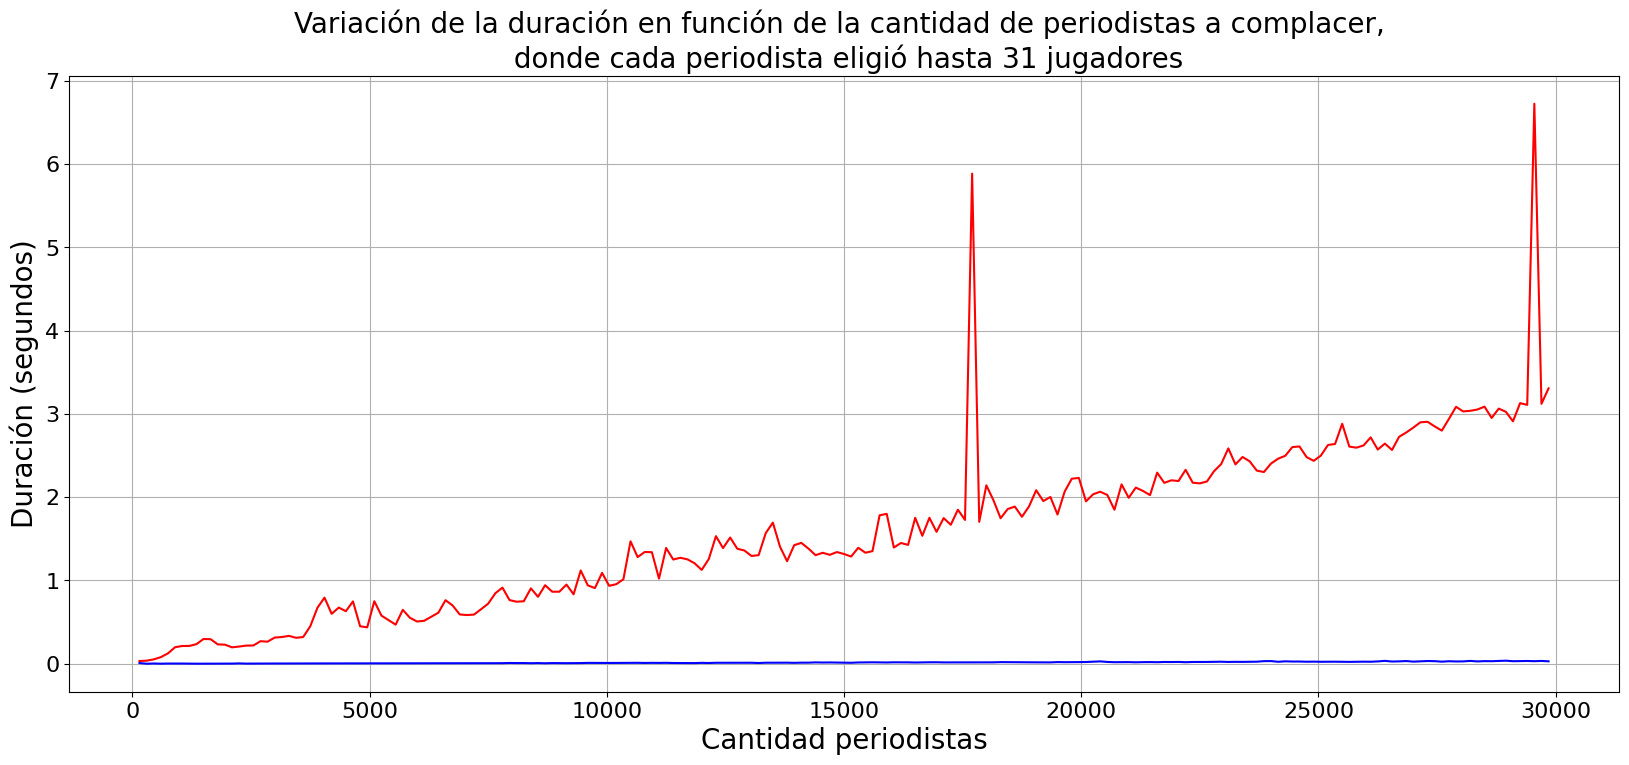

In [36]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_31, color='blue', label='Backtracking')
plt.plot(cantidad_periodistas, tiempos_ejecucion_perfo_31_lp, color='red', label='Programación lineal entera')
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer, \n donde cada periodista eligió hasta 31 jugadores', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Aproximación usando Programación Lineal y Redondeo

In [ ]:
def solucion_para_Scaloni_LP_aprox(pedidos_de_prensa):
    b = len(max(pedidos_de_prensa))
    preseleccion = obtener_todos_jugadores(pedidos_de_prensa)
    tiempo_inicial = time.time()
    prob = pulp.LpProblem("Scaloni", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", preseleccion, lowBound=0, upBound=1, cat="Continuous")
    prob += pulp.lpSum([x[i] for i in preseleccion])
    
    for pedido in pedidos_de_prensa:
        prob += pulp.lpSum([x[jugador] for jugador in pedido]) >= 1
    prob.solve()
    
    # Redondeamos el resultado final
    solucion = [i for i in preseleccion if pulp.value(x[i]) >= 1/b]
    
    tiempo_final = time.time()
    tiempo_ejecucion = tiempo_final - tiempo_inicial
    return solucion, tiempo_ejecucion

In [ ]:
solucion_5_lp, tiempo_ejecucion_5_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_5)
solucion_7_lp, tiempo_ejecucion_7_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_7)
solucion_10_pocos_lp, tiempo_ejecucion_10_pocos_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_10_pocos)
solucion_10_varios_lp, tiempo_ejecucion_10_varios_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_10_varios)
solucion_10_todos_lp, tiempo_ejecucion_10_todos_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_10_todos)
solucion_15_lp, tiempo_ejecucion_15_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_15)
solucion_20_lp, tiempo_ejecucion_20_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_20)
solucion_50_lp, tiempo_ejecucion_50_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_50)
solucion_75_lp, tiempo_ejecucion_75_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_75)
solucion_100_lp, tiempo_ejecucion_100_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_100)
solucion_200_lp, tiempo_ejecucion_200_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_200)

# Probamos con volumenes de datos mayores:
solucion_300k_lp, tiempo_ejecucion_300k_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_300k_nuestro)
solucion_30k_lp, tiempo_ejecucion_30k_lp = solucion_para_Scaloni_LP_aprox(pedidos_prensa_30k_nuestro)

In [ ]:
resultados_obtenidos_lp = [solucion_5_lp, solucion_7_lp, solucion_10_pocos_lp, solucion_10_varios_lp, solucion_10_todos_lp,\
                        solucion_15_lp, solucion_20_lp,solucion_50_lp, solucion_75_lp, solucion_100_lp, solucion_200_lp, solucion_300k_lp, solucion_30k_lp]
arreglar_resultados(resultados_obtenidos_lp)

tiempos_ejecucion_lp = [tiempo_ejecucion_5_lp, tiempo_ejecucion_7_lp, tiempo_ejecucion_10_pocos_lp, tiempo_ejecucion_10_varios_lp,\
                      tiempo_ejecucion_10_todos_lp, tiempo_ejecucion_15_lp, tiempo_ejecucion_20_lp, tiempo_ejecucion_50_lp,\
                      tiempo_ejecucion_75_lp, tiempo_ejecucion_100_lp, tiempo_ejecucion_200_lp, tiempo_ejecucion_300k_lp, tiempo_ejecucion_30k_lp]

# Imprime los resultados obtenidos y los esperados en una tabla
resultados_lp = []
i = 0
for resultado_esperado in resultados_esperados:
  es_correcto = "Sí" if resultado_esperado.cantidad_minima == len(resultados_obtenidos_lp[i]) and \
    verificar_solucion_para_Scaloni(pedidos_prensa[i],resultados_obtenidos_lp[i]) else "No"
  resultados_lp.append([resultado_esperado.nombre_archivo, resultado_esperado.cantidad_minima, len(resultados_obtenidos_lp[i]), es_correcto, tiempos_ejecucion_lp[i]]) 
  i += 1

print(tabulate(resultados_lp, headers=['Archivo', 'Cantidad mínima esperada', 'Cantidad mínima obtenida', 'Se obtuvo el resultado esperado?', 'Tiempo de ejecución (s)']))


Mostramos el resultado de los sets de datos de mayor volumen

In [ ]:
print("Mínimo de jugadores para 300k datos: ", len(solucion_300k_lp))
print("Mínimo de jugadores para 30k datos: ", len(solucion_30k_lp))

Vamos a verificar si la relación hallada r(A) = b se verifica

In [ ]:
def relacion_aproximacion(pedidos_de_prensa, solucion, optimo):
    b = len(max(pedidos_de_prensa))
    r = len(solucion) / optimo
    return r, b

In [ ]:
from tabulate import tabulate

table_data = []
i = 0
for resultado_esperado in resultados_esperados:
    r, b = relacion_aproximacion(pedidos_prensa[i], resultados_obtenidos_lp[i], resultado_esperado.cantidad_minima)
    row = [
        resultado_esperado.nombre_archivo,
        resultado_esperado.cantidad_minima,
        len(resultados_obtenidos_lp[i]),
        b,
        r
    ]
    if r <= b:
        row.append("Sí")
    else:
        row.append("No")
    table_data.append(row)
    i += 1

headers = ["Archivo", "Óptimo", "Aproximación", "b", "r(A)", "Cumple relación de aproximación"]

print(tabulate(table_data, headers=headers))


##### Mediciones de tiempo

In [ ]:
def obtener_soluciones_LP_aprox(pedidos_prensa):
    soluciones = []
    i = 0
    for pedidos in pedidos_prensa:
        soluciones.append(solucion_para_Scaloni_LP_aprox(pedidos))
        i += 1
    return soluciones

resultados_periodistas_lp_aprox = obtener_soluciones_LP_aprox(pedidos_prensa_periodistas_graficar)
resultados_jugadores_lp_aprox = obtener_soluciones_LP_aprox(pedidos_prensa_jugadores_graficar) 

In [ ]:
soluciones_periodistas_lp_aprox = [len(sol[0]) for sol in resultados_periodistas_lp_aprox]
tiempos_ejecucion_periodistas_lp_aprox = [sol[1] for sol in resultados_periodistas_lp_aprox]
cantidad_jugadores_periodistas_lp_aprox = [i for i in range(150, 30000,150)]

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_jugadores_periodistas_lp_aprox, tiempos_ejecucion_periodistas_lp_aprox)
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer,\n donde cada periodista eligió hasta 7 jugadores', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
soluciones_jugadores_lp_aprox = [len(sol[0]) for sol in resultados_jugadores_lp_aprox]
tiempos_ejecucion_jugadores_lp_aprox = [sol[1] for sol in resultados_jugadores_lp_aprox]
cantidad_jugadores_jugadores_lp_aprox = [i for i in range(150, 30000,150)] 

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(cantidad_jugadores_jugadores_lp_aprox, tiempos_ejecucion_jugadores_lp_aprox)
plt.xlabel('Cantidad periodistas', fontsize=20)
plt.ylabel('Duración (segundos)', fontsize=20)
plt.title('Variación de la duración en función de la cantidad de periodistas a complacer,\n donde cada periodista eligió hasta 31 jugadores', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Algoritmo Greedy

In [ ]:
from collections import Counter

def ordenar_jugadores_por_apariciones(pedidos_de_la_prensa):
    jugadores = [jugador for lista in pedidos_de_la_prensa for jugador in lista]
    contador_jugadores = Counter(jugadores)
    jugadores_ordenados = sorted(contador_jugadores, key=lambda jugador: contador_jugadores[jugador], reverse=True)
    return jugadores_ordenados

def solucion_greedy(pedidos_de_la_prensa):
    tiempo = time.time()
    i = 0
    solucionado = False
    solucion = []
    jugadores_ordenados = ordenar_jugadores_por_apariciones(pedidos_de_la_prensa)
    while i < len(jugadores_ordenados) and not solucionado:
        jugador_actual = jugadores_ordenados[0]
        solucion.append(jugador_actual)
        
        if verificar_solucion_para_Scaloni(pedidos_de_la_prensa, solucion):
            solucionado = True
        else:
            pedidos_de_la_prensa = [lista for lista in pedidos_de_la_prensa if jugador_actual not in lista]
            jugadores_ordenados = ordenar_jugadores_por_apariciones(pedidos_de_la_prensa)
        
        i += 1
    tiempo = time.time() - tiempo
    return solucion, tiempo

In [ ]:
solucion_5, tiempo_ejecucion_5 = solucion_greedy(pedidos_prensa_5)
solucion_7, tiempo_ejecucion_7 = solucion_greedy(pedidos_prensa_7)
solucion_10_pocos, tiempo_ejecucion_10_pocos = solucion_greedy(pedidos_prensa_10_pocos)
solucion_10_varios, tiempo_ejecucion_10_varios = solucion_greedy(pedidos_prensa_10_varios)
solucion_10_todos, tiempo_ejecucion_10_todos = solucion_greedy(pedidos_prensa_10_todos)
solucion_15, tiempo_ejecucion_15 = solucion_greedy(pedidos_prensa_15)
solucion_20, tiempo_ejecucion_20 = solucion_greedy(pedidos_prensa_20)
solucion_50, tiempo_ejecucion_50 = solucion_greedy(pedidos_prensa_50)
solucion_75, tiempo_ejecucion_75 = solucion_greedy(pedidos_prensa_75)
solucion_100, tiempo_ejecucion_100 = solucion_greedy(pedidos_prensa_100)
solucion_200, tiempo_ejecucion_200 = solucion_greedy(pedidos_prensa_200)